### Задачи проекта:

Необходимо провести маркетинговый аналитиз развлекательного приложения. Несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей было вложено много денег, но без результата. Необходимо разобраться в причинах этой ситуации.

В нашем распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нужно изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данных о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from datetime import datetime, timedelta

pd.options.display.float_format = '{:.2f}'.format
%precision %.2f

'%.2f'

### 1.1. Положите данные о визитах, заказах и рекламных тратах в переменные.

In [2]:
try: 
    visits = pd.read_csv('visits_info.csv' ) # журнал сессий
    orders = pd.read_csv('orders_info.csv') # покупки
    costs = pd.read_csv('costs_info.csv') # траты на рекламу

except FileNotFoundError:
    visits = pd.read_csv('/datasets/visits_info.csv' ) #яндексовский путь
    orders = pd.read_csv('/datasets/orders_info.csv') 
    costs = pd.read_csv('/datasets/costs_info.csv') 

### 1.2. Подготовьте данные к анализу. Убедитесь, что тип данных во всех колонках соответствует значениям. Проверьте отсутствие дубликатов.

In [3]:
# напишем функцию, выводящую общую информацию по кажому датасету, первые 10 строк, информацию о пропусках и дубликатах
for df in [visits, orders, costs]:
    df.info()
    display(df.sample(10, random_state=1))
    print(df.isna().mean())
    print('duplicates:', df.duplicated().sum())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
211274,738535139711,UK,Android,organic,09.05.2019 15:06,09.05.2019 15:48
273259,680497695721,Germany,Android,LeapBob,02.09.2019 14:07,02.09.2019 14:11
205897,728963351414,United States,Mac,organic,29.10.2019 10:45,29.10.2019 10:47
297860,174899252198,UK,PC,LeapBob,11.10.2019 01:38,11.10.2019 01:47
169513,513791433815,United States,Android,TipTop,02.10.2019 15:05,02.10.2019 15:29
68421,332224842734,United States,PC,organic,07.07.2019 21:03,07.07.2019 21:35
53262,112607694631,United States,Mac,FaceBoom,25.06.2019 00:17,25.06.2019 00:52
27056,797073249411,United States,Android,organic,28.05.2019 09:38,28.05.2019 09:38
226350,531038849208,UK,Android,OppleCreativeMedia,08.06.2019 14:39,08.06.2019 15:17
279171,856315246559,UK,PC,OppleCreativeMedia,14.09.2019 04:52,14.09.2019 04:56


User Id         0.00
Region          0.00
Device          0.00
Channel         0.00
Session Start   0.00
Session End     0.00
dtype: float64
duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
32012,419263491450,2019-07-30 23:59:07,4.99
38295,483568708610,2019-10-12 16:12:59,4.99
24544,448476047447,2019-10-16 06:11:23,4.99
29442,520659310653,2019-06-15 09:43:35,4.99
6270,680317225380,2019-07-05 13:01:50,4.99
11811,106927599817,2019-08-10 23:28:13,4.99
25721,854016361986,2019-10-21 21:52:12,4.99
12504,772315845552,2019-08-14 19:50:32,4.99
39984,662705152081,2019-10-29 13:53:48,4.99
13258,268123139092,2019-08-19 06:41:49,4.99


User Id    0.00
Event Dt   0.00
Revenue    0.00
dtype: float64
duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
1462,2019-05-23,WahooNetBanner,7.20
510,2019-09-28,RocketSuperAds,11.38
612,2019-07-12,TipTop,288.60
1322,2019-07-02,OppleCreativeMedia,14.75
993,2019-08-02,AdNonSense,26.25
190,2019-05-11,MediaTornado,11.52
1716,2019-08-05,lambdaMediaAds,4.00
1048,2019-09-26,AdNonSense,34.65
1407,2019-09-25,OppleCreativeMedia,16.50
881,2019-10-09,YRabbit,3.84


dt        0.00
Channel   0.00
costs     0.00
dtype: float64
duplicates: 0


In [4]:
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower().str.replace(' ','_')

In [5]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'], format='%d.%m.%Y %H:%M') 
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%d.%m.%Y %H:%M')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Вывод

Мы ознакомились с данными, состоящими из трех датасетов, для удобства работы преобразовали названия столбцов. Также данные о времени во всех датасетах мы преобразовали в корректный, временной тип. Заметим, что пропусков и дубликатов не обнаружено.

# Шаг 2. Проведите исследовательский анализ данных

### 2.1. Создайте пользовательские профили. Определите минимальную и максимальную даты привлечения пользователей

In [6]:
# создадим функцию
def get_profiles(sessions, orders, ad_costs):    
    
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first', 'region': 'first', 'device': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # определяем, есть ли ID пользователей из profiles в orders
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']   
        
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [7]:
# профили пользователей
profiles = get_profiles(visits, orders, costs) 
profiles

,user_id,first_ts,channel,region,device,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,United States,Mac,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:00,FaceBoom,United States,iPhone,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:00,organic,France,iPhone,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:00,AdNonSense,Germany,PC,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:00,YRabbit,United States,iPhone,2019-10-02,2019-10-01,False,0.23
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:00,TipTop,United States,iPhone,2019-09-28,2019-09-01,False,3.50
150004,999975439887,2019-10-21 00:35:00,organic,UK,PC,2019-10-21,2019-10-01,False,0.00
150005,999976332130,2019-07-23 02:57:00,TipTop,United States,iPhone,2019-07-23,2019-07-01,False,2.60
150006,999979924135,2019-09-28 21:28:00,MediaTornado,United States,PC,2019-09-28,2019-09-01,False,0.21


In [8]:
# минимальная и максимальная дата привлечения пользователей
print(profiles['first_ts'].min())
print(profiles['first_ts'].max())

2019-05-01 00:00:00
2019-10-27 23:59:00


### 2.2. Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [10]:
#  Из каких стран приходят посетители? 
profiles_countries=profiles.groupby('region').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
profiles_countries['%user']=profiles_countries['user_id']/profiles_countries['user_id'].sum()*100

# Какие страны дают больше всего платящих пользователей? 
profiles_countries_payer=profiles.groupby('region').agg({'payer': 'sum'}).sort_values(by = 'payer',ascending=False)
profiles_countries_payer['%payer']=profiles_countries_payer['payer']/profiles_countries_payer['payer'].sum()*100

# доля покупателями по стране от всех покупателей
profiles_countries_payer_mean=profiles.groupby('region').agg({'payer': 'mean'}).sort_values(
    by = 'payer',ascending=False).rename(columns={'payer': '%_payers_from_users'})
            
profiles_countries.merge(profiles_countries_payer, on='region').merge (profiles_countries_payer_mean, on='region')

,user_id,%user,payer,%payer,%_payers_from_users
region,,,,,
United States,100002,66.66,6902.00,77.72,0.07
UK,17575,11.72,700.00,7.88,0.04
France,17450,11.63,663.00,7.47,0.04
Germany,14981,9.99,616.00,6.94,0.04


In [11]:
print("всего платящих пользователей:", profiles_countries_payer['payer'].sum()) 
print('доля платящих пользователей от всех: {:.2f}%'.format(
    profiles_countries_payer['payer'].sum()/profiles_countries['user_id'].sum()*100))


всего платящих пользователей: 8881.0
доля платящих пользователей от всех: 5.92%


In [9]:
report = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
report.columns = ['Пользователи', 'Платящие пользователи', '% платящих']
report.sort_values(by = 'Пользователи', ascending = False).style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
region,,,
United States,100002,6902,6.90%
UK,17575,700,3.98%
France,17450,663,3.80%
Germany,14981,616,4.11%


### 2.3. Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [12]:
# Какими устройствами они пользуются? 
profiles_devices = profiles.groupby('device').agg({'user_id': 'nunique'}).sort_values(by = 'user_id',ascending=False)
profiles_devices['%users']=profiles_devices['user_id']/profiles_devices['user_id'].sum()*100
profiles_devices
# С каких устройств чаще всего заходят платящие пользователи?
profiles_devices_payer=profiles.groupby('device').agg({'payer': 'sum'}).sort_values(by = 'payer',ascending=False)
profiles_devices_payer['%payer from all payers']=profiles_devices_payer['payer']/profiles_devices_payer['payer'].sum()*100
profiles_devices_total = profiles_devices.merge(profiles_devices_payer, on='device')


In [13]:
profiles_devices_total['%payers from users'] = profiles_devices_total['payer']/profiles_devices_total['user_id']*100
profiles_devices_total.sort_values('%payers from users', ascending=False)

,user_id,%users,payer,%payer from all payers,%payers from users
device,,,,,
Mac,30042,20.03,1912.00,21.53,6.36
iPhone,54479,36.32,3382.00,38.08,6.21
Android,35032,23.35,2050.00,23.08,5.85
PC,30455,20.30,1537.00,17.31,5.05


Среди всех пользователей, у большинства айфоны - 36.32%, у остальных устройств около 20%.
Заметим, что среди пользователей Mac и iPhone доля платящих совсем немного выше, на полтора процента, 6.36 и 6.21, что немного выше средней доли платящих пользователей от всех пользователей, которых как мы посчитали всего 5.92%.

### 2.4. Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [14]:
# По каким рекламным каналам шло привлечение пользователей? 
profiles_channels=profiles.groupby('channel').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
profiles_channels['%users']=profiles_channels['user_id']/profiles_channels['user_id'].sum()*100

# Какие каналы приносят больше всего платящих пользователей?
profiles_channels_payer=profiles.groupby('channel').agg({'payer': 'sum'}).sort_values(by = 'payer',ascending=False)
profiles_channels_payer['% payers from all payers']=profiles_channels_payer['payer']/profiles_channels_payer['payer'].sum()*100
profiles_channels_total = profiles_channels.merge(profiles_channels_payer, on='channel')

In [15]:
profiles_channels_total['%payers from users']=profiles_channels_total['payer']/profiles_channels_total['user_id']*100
profiles_channels_total.sort_values('%payers from users', ascending=False)

,user_id,%users,payer,% payers from all payers,%payers from users
channel,,,,,
FaceBoom,29144,19.43,3557.00,40.05,12.20
AdNonSense,3880,2.59,440.00,4.95,11.34
lambdaMediaAds,2149,1.43,225.00,2.53,10.47
TipTop,19561,13.04,1878.00,21.15,9.60
RocketSuperAds,4448,2.97,352.00,3.96,7.91
WahooNetBanner,8553,5.70,453.00,5.10,5.30
YRabbit,4312,2.87,165.00,1.86,3.83
MediaTornado,4364,2.91,156.00,1.76,3.57
LeapBob,8553,5.70,262.00,2.95,3.06


Среи тех, кто пришел из FaceBoom выской процент платных пользователей - 12.2%, а также у AdNonSense и lambdaMediaAds - больше 10%, у TipTop 9.6%. Эти пользователи становятся платными чаще пришедших из других каналов. Самый низкий результат у OppleCreativeMedia и LeapBob около 3%.

### Вывод

Результат — 150008 пользовательских профилей, в каждом из которых есть данные о дате первого посещения и рекламном источнике.
Данны о привлечении пользователей с 1 мая 2019 года по 27 октября 2019 года (как и заявлено в описании).
Посетители приходят из США, Соединенного Королевства, Франции и Германии. 
Всего платящих пользователей около 6%. 

*Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?*

Больше всего платящих пользователей приходят из США, 78% от всех платящих, остальные страны имеют схожие результат в районе 7-8%. Что касается доли посетителей, ставших покупателями, то по США эта доля выше, чем в остальных странах, 7% по сравнению с 4% по остальным.Таким образом из США приходит больше всего покупателей в абсолютных числах, а также и в относительных - в США бóльшая доля пользователей становится покупателями.

*Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?*

Чаще всего пользователи заходят с iPhone (36% от всех пользователей), также используют Android, PC	и Mac - около 20% в каждом случае. Среди пользователей Mac и iPhone доля платящих совсем немного выше, на полтора процента, 6.36 и 6.21, что немного выше средней доли платящих пользователей от всех пользователей, 5.92%.

*По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?*

Большинство пришедших пользователей - "органические", 38%, остальные приходят из FaceBoom - 19%, TipTop	- 13 % и далее около 5%
из OppleCreativeMedia, LeapBob	и WahooNetBanner. Что касается платящих пользователей, то среди тех, кто пришел из FaceBoom довольно выский процент платных пользователей - 12.2%, а также у AdNonSense и lambdaMediaAds - больше 10%, у TipTop 9.6%. Эти пользователи становятся платными чаще пришедших из других каналов. Самый низкий результат у OppleCreativeMedia и LeapBob - около 3%.

# Шаг 3. Постройте отчёты и посчитайте метрики

Посчитайте метрики по трём направлениям: продукт, продажи и маркетинг.

## Продукт:

### 3.1.1. Выясните, сколько людей пользуются приложением в день, неделю и месяц: рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период. Отобразите изменения метрик во времени на графиках.

In [16]:
# Чтобы посчитать недельную и месячную активность пользователей выделим год, месяц и неделю начала сессии в отдельные столбцы
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].astype('datetime64[M]') ###change 
visits['session_week'] = visits['session_start'].astype('datetime64[W]') ###change 
visits['session_date'] = visits['session_start'].dt.date

In [17]:
visits.head(5)

,user_id,region,device,channel,session_start,session_end,session_year,session_month,session_week,session_date
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00,2019,2019-05-01,2019-04-25,2019-05-01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00,2019,2019-05-01,2019-04-25,2019-05-01
2,590706206550,United States,Mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00,2019,2019-05-01,2019-04-25,2019-05-01
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:00,2019-05-01 00:54:00,2019,2019-05-01,2019-04-25,2019-05-01
4,349773784594,United States,Mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00,2019,2019-05-01,2019-04-25,2019-05-01


In [18]:
dau_total = visits.groupby('session_date').agg({'user_id': 'nunique'}).mean()
wau_total = visits.groupby('session_week').agg({'user_id': 'nunique'}).mean()
mau_total = visits.groupby('session_month').agg({'user_id': 'nunique'}).mean()

In [19]:
print('DAU за весь период:', int(dau_total))
print('WAU за весь период:', int(wau_total))
print('MAU за весь период:', int(mau_total))

DAU за весь период: 1684
WAU за весь период: 7942
MAU за весь период: 28989


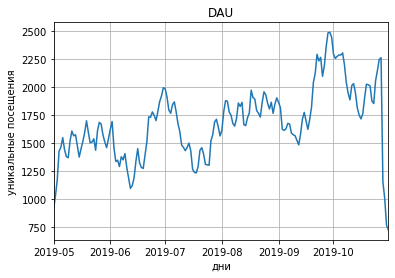

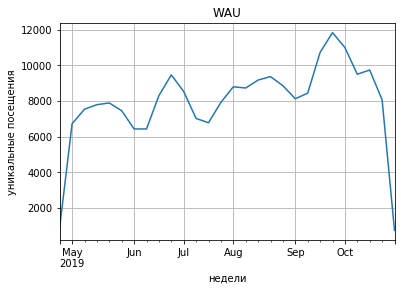

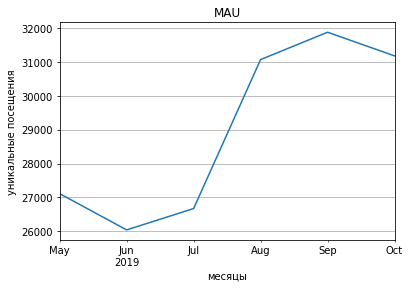

In [20]:
visits.groupby('session_date').agg({'user_id': 'nunique'}).plot(grid=True, title='DAU', legend=False)
plt.xlabel('дни')
plt.ylabel('уникальные посещения')
plt.show()

visits.groupby('session_week').agg({'user_id': 'nunique'}).plot(grid=True, title="WAU", legend=False)
plt.xlabel('недели')
plt.ylabel('уникальные посещения')
plt.show()

visits.groupby('session_month').agg({'user_id': 'nunique'}).plot(grid=True, title="MAU", legend=False);
plt.xlabel('месяцы')
plt.ylabel('уникальные посещения')
plt.show()


DAU, то есть среднее количество уникальных пользователей за день, в среднем за период было 1684. В среднем за неделю за весь период к нам приходило 7942 уникальных пользователей, а за месяц 28989. Это средние средних, так как со временем эти показатели менялись, в целом показывая тенденции к росту. На графике MAU помесячного среднего по уникальным посетителям хорошо заментно, что с июля начался рост посетителей. Пик роста уникальных пользователей пришелся на сентябрь и в октябре начал снижаться. Заметим, что наши наблюдения за октябр не совсем полные, не хватает 4.х последних дней.

### 3.1.2. Изучите число пользовательских сессий. Постройте гистограмму, отражающую распределение общего числа сессий в день, и выведите среднее количество сессий в день. Изучать изменение этой метрики во времени необязательно.

In [21]:
# Сколько сессий в день?
# считаем количество сессий по user_id т.к. у нас нет данных по session_id
print("количество сессий в день:", int(visits.groupby('session_date').agg({'user_id': 'count'}).mean()))
print("количество сессий в неделю:", int(visits.groupby('session_week').agg({'user_id': 'count'}).mean()))
print("количество сессий в месяц:", int(visits.groupby('session_month').agg({'user_id': 'count'}).mean()))

количество сессий в день: 1684
количество сессий в неделю: 11067
количество сессий в месяц: 51650


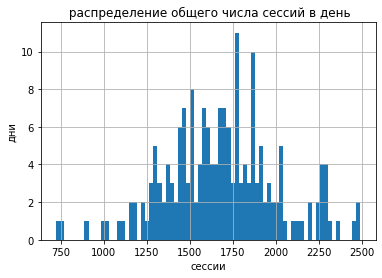

In [22]:
visits.groupby('session_date').agg({'user_id': 'count'}).rename(
    columns={'user_id': ' распределение общего числа сессий в день'}).hist(grid=True, bins=75)
plt.xlabel('сессии')
plt.ylabel('дни')
plt.show()

In [23]:
# сравним количество сессий и уникальных пользователей в день 
sessions_per_user = visits.groupby(['session_date']).agg({'user_id': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
# делим число сессий на количество пользователей
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])
sessions_per_user.mean() # пользователь в день в среднем  проводит в приложении 1 сессию

n_sessions          1684.24
n_users             1684.24
sessions_per_user      1.00
dtype: float64

In [24]:
#sessions_per_user.query('sessions_per_user > 1') # только один раз за 184 дня пользователь зашел дважды в приложение

In [25]:
# считаем количество сессий — всех и уникальных в неделю
sessions_per_user = visits.groupby(['session_week']).agg({'user_id': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
# делим число сессий на количество пользователей
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])
sessions_per_user.mean()
# а вот в неделю один пользователь в среднем проводит в приложении уже 1.37 сессию. 

n_sessions          11067.89
n_users              7942.21
sessions_per_user       1.37
dtype: float64

In [26]:
# считаем количество сессий — всех и уникальных в месяц
sessions_per_user = visits.groupby(['session_month']).agg({'user_id': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])
sessions_per_user.mean()
# в месяц один пользователь в среднем проводит в приложении 1.78 сессию. 

n_sessions          51650.17
n_users             28989.17
sessions_per_user       1.78
dtype: float64

В среднем в день в приложение заходят 1684 раз. Как правило в день пользователи не повторяются и одна сессия - это один уникальный пользователь. 
Т.е. пользователь в среднем заходит в приложение максимум раз в день, но в неделю немного больше, т.е. есть повторные, и в среднем это 1.37 сессий, а в месяц - 1.78. Т.е. в среднем, пользователи в приложение меньше пары раз за месяц.

### 3.1.3. Узнайте, сколько длится одна сессия. Постройте гистограмму, отражающую распределение длительности сессий. Применяя метод describe(), постройте таблицу с параметрами распределения. Изучать изменение этой метрики во времени необязательно.

In [27]:
# Сколько длится одна сессия?
# считаем ASL
visits['session_duration_sec'] = (visits['session_end'] - visits['session_start']).dt.seconds
asl = visits['session_duration_sec'].mean()
print('в среднем одна сессия длится {:.2f} секунд или {:.2f} минут'.format(asl, asl/60))

в среднем одна сессия длится 1800.08 секунд или 30.00 минут


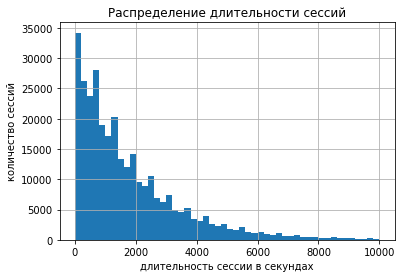

In [28]:
visits['session_duration_sec'].hist(bins=50, range=(0, 10000))
plt.title('Распределение длительности сессий')
plt.xlabel('длительность сессии в секундах')
plt.ylabel('количество сессий')
plt.show()

In [29]:
visits['session_duration_sec'].describe()

count   309901.00
mean      1800.08
std       1803.19
min          0.00
25%        540.00
50%       1260.00
75%       2520.00
max      22260.00
Name: session_duration_sec, dtype: float64

В среднем пользователи проводят в приложении около 30 минут (медиана - 21 минута). Это довольно много. 

### Продажи:

### 3.2.1. Исследуйте, сколько времени в среднем проходит с момента первого посещения до покупки. Изучать изменение этой метрики во времени необязательно.

In [30]:
# Когда люди начинают покупать?
purchases=orders.merge(profiles, on='user_id') #создадим таблицу, где будет информация о покупках и первом посещении 

In [31]:
# создадим таблицу, где будет информация только первом посещении и первой покупке на пользователя
#  и посчитаем разницу во вемени между посещением и покупкой
purchases_first = purchases.sort_values(by=['user_id', 'event_dt']).groupby(
    'user_id').agg({'event_dt': 'first', 'first_ts': 'first' }).rename(columns={'event_dt': 'first_pur'}).reset_index()
 
purchases_first['time']=purchases_first['first_pur']-purchases_first['first_ts']  
purchases_first.head(5)

,user_id,first_pur,first_ts,time
0,599326,2019-05-07 20:59:09,2019-05-07 20:58:00,0 days 00:01:09
1,46006712,2019-06-30 03:46:52,2019-06-30 03:46:00,0 days 00:00:52
2,374052872,2019-08-16 07:44:47,2019-08-08 15:42:00,7 days 16:02:47
3,414791703,2019-05-04 18:06:41,2019-05-03 12:01:00,1 days 06:05:41
4,785077127,2019-06-30 18:35:15,2019-06-27 08:31:00,3 days 10:04:15


In [32]:
purchases_first['time_sec']=purchases_first['time']
purchases_first['time_sec']=purchases_first['time_sec']/ np.timedelta64(1, 's')
purchases_first['time_min']=purchases_first['time_sec']/60
purchases_first

,user_id,first_pur,first_ts,time,time_sec,time_min
0,599326,2019-05-07 20:59:09,2019-05-07 20:58:00,0 days 00:01:09,69.00,1.15
1,46006712,2019-06-30 03:46:52,2019-06-30 03:46:00,0 days 00:00:52,52.00,0.87
2,374052872,2019-08-16 07:44:47,2019-08-08 15:42:00,7 days 16:02:47,662567.00,11042.78
3,414791703,2019-05-04 18:06:41,2019-05-03 12:01:00,1 days 06:05:41,108341.00,1805.68
4,785077127,2019-06-30 18:35:15,2019-06-27 08:31:00,3 days 10:04:15,295455.00,4924.25
...,...,...,...,...,...,...
8876,999625937544,2019-10-26 06:24:27,2019-10-26 06:24:00,0 days 00:00:27,27.00,0.45
8877,999645428220,2019-10-01 05:36:23,2019-10-01 05:35:00,0 days 00:01:23,83.00,1.38
8878,999659859721,2019-09-08 01:28:08,2019-09-04 10:33:00,3 days 14:55:08,312908.00,5215.13
8879,999779032958,2019-07-05 23:28:13,2019-07-04 10:56:00,1 days 12:32:13,131533.00,2192.22


In [33]:
# посчитаем, сколько времени в медианном среднем проходит с момента первого посещения до покупки
purchases_first['time'].median()  

Timedelta('0 days 00:01:10')

In [34]:
purchases_first['time'].describe()

count                      8881
mean     1 days 21:11:50.693052
std      6 days 00:52:20.165837
min             0 days 00:00:00
25%             0 days 00:00:41
50%             0 days 00:01:10
75%             1 days 11:28:52
max           132 days 03:54:55
Name: time, dtype: object

In [35]:
purchases_first['time_min'].describe()

count     8881.00
mean      2711.84
std       8692.34
min          0.00
25%          0.68
50%          1.17
75%       2128.87
max     190314.92
Name: time_min, dtype: float64

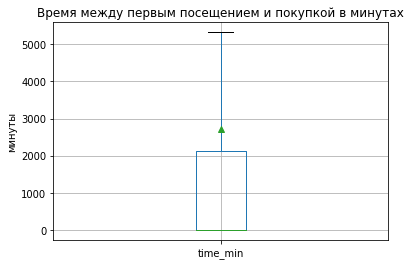

In [36]:
purchases_first.boxplot(column=['time_min'], showmeans=True, showfliers=False)
plt.ylabel('минуты')
plt.xlabel('')
plt.title('Время между первым посещением и покупкой в минутах')
plt.suptitle("")
plt.show()

Медианное среднее с момента первого посещения до покупки чуть больше минуты - 70 секунд. Мы наблюдаем очень много выбросов, поэтому арифметическое среднее "зашкаливает", оно составляет 1 день 21 час. Тем не менее, 75% всех покупателей совершили свою первую покупку меньше чем через один день и 11 часов после первого захода. Самая быстрая покупка была мгновенная, сразу, я самая долгая покупка была сделана после 132 дней после первого захода. Но, как известно, лучше поздно, чем никогда.

### 3.2.2. Рассчитайте среднее число покупок на одного покупателя за день, неделю и месяц. Постройте графики изменения этих метрик во времени.

In [37]:
purchases['purchase_date'] = purchases['event_dt'].dt.date
purchases['purchase_month'] = purchases['event_dt'].astype('datetime64[M]') 
purchases['purchase_week'] = purchases['event_dt'].astype('datetime64[W]')

In [38]:
report_day=purchases.groupby('purchase_date').agg({'user_id': 'nunique','event_dt': 'nunique'})
report_day['orders_per_payer'] = report_day['event_dt']/report_day['user_id']
orders_mean_day=report_day['orders_per_payer'].mean()
print('Среднее число покупок на одного покупателя за день: {:.3f}'.format(orders_mean_day))

report_week=purchases.groupby('purchase_week').agg({'user_id': 'nunique','event_dt': 'nunique'})
report_week['orders_per_payer'] = report_week['event_dt']/report_week['user_id']
orders_mean_week=report_week['orders_per_payer'].mean()
print('Среднее число покупок на одного покупателя за неделю: {:.3f}'.format(orders_mean_week))

report_month=purchases.groupby('purchase_month').agg({'user_id': 'nunique','event_dt': 'nunique'})
report_month['orders_per_payer'] = report_month['event_dt']/report_month['user_id']
orders_mean_month=report_month['orders_per_payer'].mean()
print('Среднее число покупок на одного покупателя за месяц: {:.3f}'.format(orders_mean_month))

Среднее число покупок на одного покупателя за день: 0.999
Среднее число покупок на одного покупателя за неделю: 1.315
Среднее число покупок на одного покупателя за месяц: 2.226


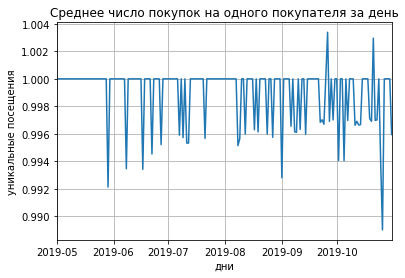

In [39]:
report_day['orders_per_payer'].plot(grid=True, title="Среднее число покупок на одного покупателя за день", legend=False)
plt.xlabel('дни')
plt.ylabel('уникальные посещения')
plt.show()

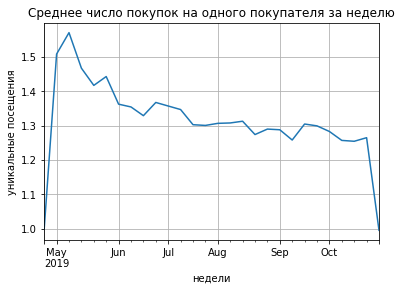

In [40]:
report_week['orders_per_payer'].plot(grid=True, title="Среднее число покупок на одного покупателя за неделю", legend=False)
plt.xlabel('недели')
plt.ylabel('уникальные посещения')
plt.show()

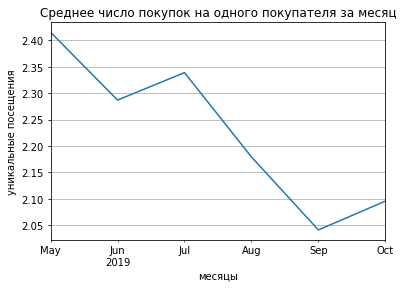

In [41]:
report_month['orders_per_payer'].plot(grid=True, title="Среднее число покупок на одного покупателя за месяц", legend=False)
plt.xlabel('месяцы')
plt.ylabel('уникальные посещения')
plt.show()

В среднем платящий пользователь совершает одну покупку в день, 1.32 в неделю и 2.23 покупки в месяц. С июля среднее число покупок на одного платящего начинает снижаться. 

### 3.2.3. Рассчитайте средний чек за день, неделю и месяц. Постройте графики изменения этих метрик во времени.

Cредний чек за день : 5.38


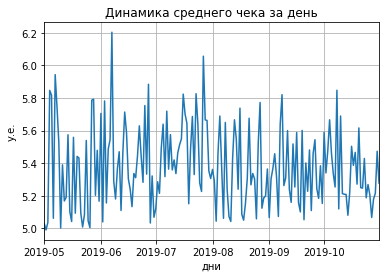

Cредний чек за неделю : 5.36


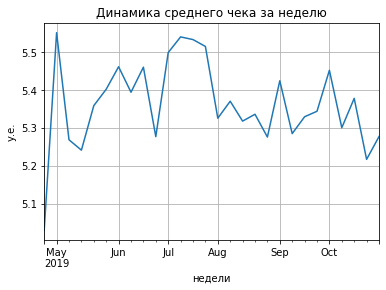

Cредний чек за месяц : 5.37


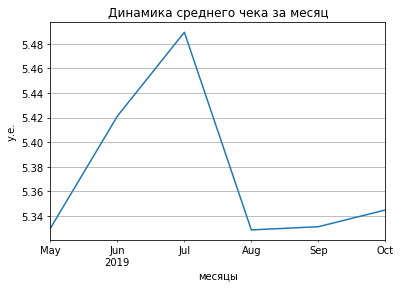

In [43]:
labels=['дни','недели','месяцы']
labels_means=['Cредний чек за день','Cредний чек за неделю','Cредний чек за месяц']
titles=['Динамика среднего чека за день','Динамика среднего чека за неделю','Динамика среднего чека за месяц']
i=0

for period in ['purchase_date','purchase_week','purchase_month']:
    report_ticket=purchases.groupby(period).agg({'revenue': 'sum','event_dt': 'count'})
    report_ticket['revenue_per_ticket'] = report_ticket['revenue']/report_ticket['event_dt']
    print(labels_means[i],': {:.2f}'.format(report_ticket['revenue_per_ticket'].mean()))
    report_ticket['revenue_per_ticket'].plot(grid=True, title=titles[i], legend=False)
    plt.xlabel(labels[i])
    plt.ylabel('у.е.')
    plt.show()
    i+=1

Средний чек за день 5.38 у.е., за неделю - 5.36, за месяц - 5.37, практически одинаковые. Рамер среднего чека достигает пика в июле и далее начинает снижаться. Возможно, мы наблюдаем сезонность, покупки как-то связанные с летним периодом.

### Маркетинг:

### 3.3.1. Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени.

In [44]:
print('Общая сумма расходов на маркетинг: {:.2f}'.format(costs['costs'].sum()))

Общая сумма расходов на маркетинг: 105497.30


In [45]:
# как траты распределены по источникам
costs_sources = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
costs_sources['% costs']=costs_sources['costs']/costs_sources['costs'].sum()*100
costs_sources

,costs,% costs
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


Более половины всех затрат (52%) были направлены на TipTop, на FaceBoom 31%, а на остальные каналы - меньше 5%.

In [46]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['costs_week_number'] = costs['dt'].astype('datetime64[W]')
costs['costs_month_number'] = costs['dt'].astype('datetime64[M]')

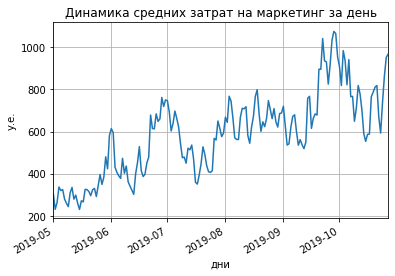

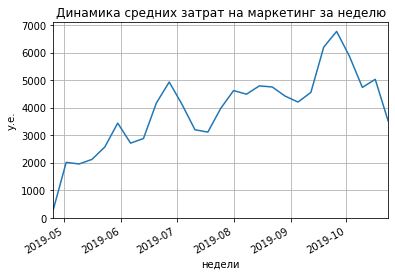

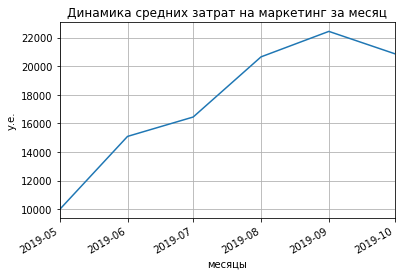

In [47]:
# как траты распределены по времени
labels=['дни','недели','месяцы']
labels_means=['Cредние траты за день','Cредние траты за неделю','Cредние траты за месяц']
titles=['Динамика средних затрат на маркетинг за день','Динамика средних затрат на маркетинг за неделю','Динамика средних затрат на маркетинг за месяц']
i=0
for period in ['dt','costs_week_number','costs_month_number']:
    report_costs = costs.groupby(period).agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
    report_costs.plot(grid=True, title=titles[i], legend=False)
    plt.xlabel(labels[i])
    plt.ylabel('у.е.')
    plt.show()
    i+=1
    

Динамика затрат показывает стабильный рост затрат, на графике затрат на маркетинг по месяцам мы выдим резкий рост с июня по сентябрь.

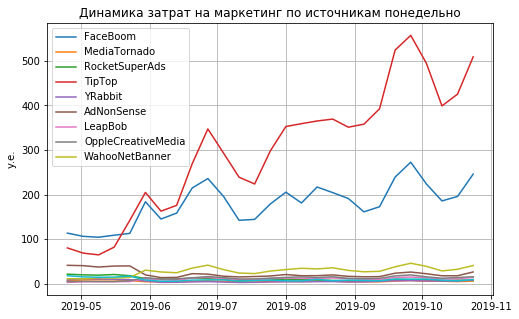

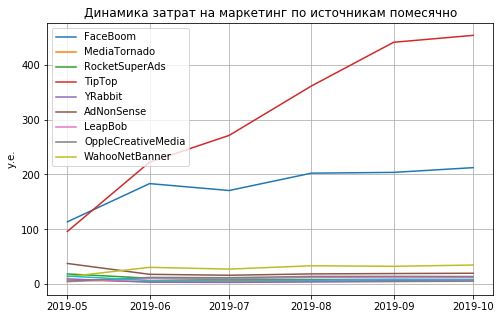

In [48]:
# визуализируем, как траты распределены по времени в зависимости от источника по неделям и месяцам
plt.figure(figsize=(8,5))
plt.grid()

for channel in costs['channel'].unique():
    plt.legend(costs['channel'].unique())
    plt.plot(costs[costs['channel'] == channel].pivot_table(
    index=['costs_week_number'], values='costs'))   
    plt.xlabel('')
plt.ylabel('у.е.')
plt.title('Динамика затрат на маркетинг по источникам понедельно')
plt.show()

plt.figure(figsize=(8,5))
plt.grid()

for channel in costs['channel'].unique():
    plt.legend(costs['channel'].unique())
    plt.plot(costs[costs['channel'] == channel].pivot_table(
    index=['costs_month_number'], values='costs'))   
    plt.xlabel('')
plt.ylabel('у.е.')
plt.title('Динамика затрат на маркетинг по источникам помесячно')
plt.show()

Затраты на FaceBoom не слишком росли со временем, сильно увеличившись только в начале периода, с мая по июнь, зато затраты на TipTop с июня переживали сильный и постоянный рост. Затраты по остальным каналам не сильно менялись со временем.

### 3.3.2. Узнайте, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитайте средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Используйте профили пользователей.

In [49]:
# Сколько в среднем стоило привлечение одного пользователя из каждого источника (расчет CPA, Cost Per Action)
costs_sources_per_user = profiles.groupby('channel').agg({'user_id':'count','acquisition_cost':'sum'}).sort_values(by='acquisition_cost', ascending=False)
costs_sources_per_user['cost_per_user'] = costs_sources_per_user['acquisition_cost']/costs_sources_per_user['user_id']
costs_sources_per_user=costs_sources_per_user.sort_values(by='cost_per_user', ascending=False).rename(columns={'user_id': 'total_users'})
costs_sources_per_user

,total_users,acquisition_cost,cost_per_user
channel,,,
TipTop,19561,54751.30,2.80
FaceBoom,29144,32445.60,1.11
AdNonSense,3880,3911.25,1.01
lambdaMediaAds,2149,1557.60,0.72
WahooNetBanner,8553,5151.00,0.60
RocketSuperAds,4448,1833.00,0.41
OppleCreativeMedia,8605,2151.25,0.25
YRabbit,4312,944.22,0.22
MediaTornado,4364,954.48,0.22


In [50]:
# Расчет среднего CAC на одного пользователя для всего проекта и для каждого источника трафика. 
# Cколько в среднем стоило привлечение одного клиента из каждого источника (расчет Customer Acquisition Cost)?
costs_sources_per_customer = profiles[profiles['payer']==True].groupby('channel').agg(
    {'user_id':'count'}).rename(columns={'user_id':'total_payers'})
costs_sources_per_customer=costs_sources_per_customer.merge(costs_sources_per_user, on='channel')

costs_sources_per_customer[
    'cost_per_customer'] = costs_sources_per_customer['acquisition_cost']/costs_sources_per_customer['total_payers']
costs_sources_per_customer=costs_sources_per_customer.reset_index()
costs_sources_per_customer.sort_values(by='cost_per_customer', ascending=False)

,channel,total_payers,total_users,acquisition_cost,cost_per_user,cost_per_customer
6,TipTop,1878,19561,54751.30,2.80,29.15
7,WahooNetBanner,453,8553,5151.00,0.60,11.37
4,OppleCreativeMedia,233,8605,2151.25,0.25,9.23
1,FaceBoom,3557,29144,32445.60,1.11,9.12
0,AdNonSense,440,3880,3911.25,1.01,8.89
9,lambdaMediaAds,225,2149,1557.60,0.72,6.92
2,LeapBob,262,8553,1797.60,0.21,6.86
3,MediaTornado,156,4364,954.48,0.22,6.12
8,YRabbit,165,4312,944.22,0.22,5.72
5,RocketSuperAds,352,4448,1833.00,0.41,5.21


In [51]:
# средний CAC на одного пользователя (для расчета, уберем органических пользователей)
costs_sources_per_customer_commerc = costs_sources_per_customer[costs_sources_per_customer['channel']!='organic']
costs_sources_per_customer_commerc['acquisition_cost'].sum()/costs_sources_per_customer_commerc['total_payers'].sum()

13.663683460691468

Средняя стоимость привелечения покупателей - 13.7 у.е. Дороэе всего обошлись пользователи из TipTop, в 29.15 у.е. и из "WahooNetBanner" - 11.37 у.е. Пользователи FaceBoom стоили меньше 9.12 у.е. и самые "дешевые" биыли из RocketSuperAds - 5.21 у.е. 
В абсолютных числах больше всего покупателей пришло из FaceBoom, и тех, кто пришли сами, т.е. "органические" пользователи.

### Выводы

Продукт:

*Сколько людей пользуются в день, неделю, месяц?*

В среднем, за весь период анализва, DAU, или количество уникальных пользователей в день, было 1684; WAU, или количество уникальных пользователей в неделю, было 7942; MAU, или количество уникальных пользователей в месяц, было 28989 человека. Заметим, что с июля наблюдается рост количества уникальный пользователей, особенно это видно на графке MAU, и своего пика он достигает в сентябре. Возможно, мы наблюдаем сезонность.

*Сколько сессий в день?*

Всего в среднем в день осуществляется 1684 сессий (что как мы видим соответствует среднему DAU).
Один пользователь в среднем проводит в приложении максимум одну сессию в день. Т.е. пользователи не заходят повторно в приложение в один и тот же день. В неделю 1.37 сессий, а в месяц - 1.78. Таким образом, в среднем, пользователи заходят в приложение чуть меньше, чем 2 раза месяц, что довольно мало.

*Сколько длится одна сессия?*

В среднем пользователи проводят в приложении около 30 минут. Однако у нас есть выбросы, и для оценки «здоровья» сессий необходимо посмотреть медианное среднее. Медианное среднее сессии - 26 минут, что является хорошим результатом, пользователи проводят много времени в приложении.
 
Продажи:

*Когда люди начинают покупать?*

Если смотрет на арифметическое среднее, то с момента первого посещения до покупки проходит 1 день и 21 час, то есть чуть менее двух дней. Однако здесь много выбросов и лучше ориенироваться на медианное среднее в одну минуту и 10 секунд. 75% всех платящих пользователей совершили свою первую покупку менее чем через один день и 11 часов. 

*Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?*
В среднем платящий пользователь совершает одну покупку в день, 1.32 покупки в неделю и 2.23 покупки в месяц. Заметим, что на графиках по неделям и мясяцам мы наблюдаем, что, начиная с июля среднее число покупок на платящего начинает снижаться, несмотря на то, что ранее мы отметили рост количества посетителей с этого же месяца. То есть заходить в приложение стало больше людей, а покупок на человека при этом стали совершать меньше.

*Какой средний чек за месяц, неделю, день?*

Средний чек за день 5.38 у.е., за неделю - 5.36, а за месяц - 5.37, то есть почти одинаковые. Заметим, что на графиках видно, что средний чек достигает пика в июля и далее начинает снижаться. Также можно отметить, что со временем общее количество совершенных покупок растет, так же как и общее количество доходов с них, однако в расчете на чек с июля оно снижается, т.е. хоть покупок и стало больше, но тратить на покупку стали со временем немного меньше.

Маркетинг:

*Сколько денег потратили? Всего / на каждый источник / по времени*
Общая сумма расходов на маркетинг: 105497 у.е. Более половины всех затрат (52%) были направлены на TipTop, на 
FaceBoom 31%, а на остальные каналы меньше 5%. Динамика трат во времени показывает стабильный рост затрат, на помесячной мы выдим резкий рост затрат начиная с июня (отсюда, возможно, и рост числа пользователей с июля). Затраты на FaceBoom не слишком росли со временем, сильно увеличившись только в начале периода, с мая по июнь, зато затраты на TipTop с июня переживали сильный и постоянный рост. Затраты по остальным каналам не сильно менялись со временем.

*Сколько в среднем стоило привлечение одного покупателя из каждого источника?*
Привелечение покупателей, т.е. не просто пользователей, а платящих пользователей обошлось в среднем в 13.7 у.е. Самые "дорогие пользователи" из TipTop, их стоимость 29.15 у.е., за ними следует пришедшие из "WahooNetBanner" - 11.37 у.е. Пользователи FaceBoom обошлись дешевле - в 9.12 у.е. и самые "дешевые" пришли из RocketSuperAds - 5.21 у.е. Заметим, что FaceBoom принес нам больше всего покупателей в абсолютных числах, а на втором месте находится органика - много покупателей пришли сами. Компании стоит серьезно задуматься над вложениями в TipTop.

# Шаг 4. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

### 4.1. Задайте функции для расчёта и визуализации LTV, ROI, удержания и конверсии. Разрешается использовать функции get_profiles(), get_retention(), get_conversion(), get_ltv(), а также plot_retention(), plot_conversion() и plot_ltv_roi() из уроков.

In [52]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [53]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [54]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

       
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [55]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [56]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [57]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [58]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

In [59]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [60]:
# исключим органических пользователей
profiles=profiles[profiles['channel'] != 'organic'] 
visits=visits[visits['channel'] != 'organic']

### 5.1. Проанализируйте общую окупаемость рекламы. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

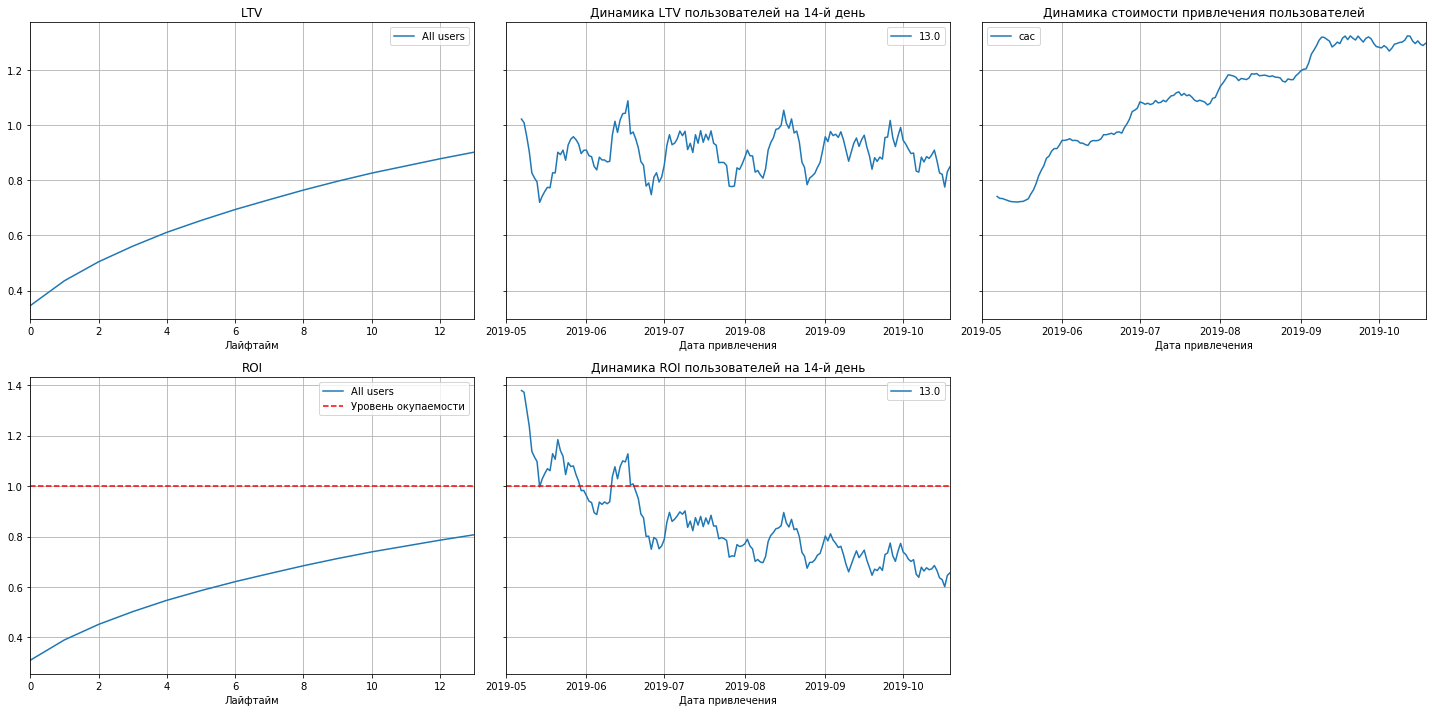

In [61]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По общим графикам можно сделать такие выводы:
В целом, реклама не окупается. ROI даже на 14-й день ниже уровня окупаемости. LTV пользователей на 14-й день довольно стабилен.
При этом стоимость привлечения пользователей с середины мая постоянно растет. Если смотреть на динамику ROI по месяцам, то начиная с конца июля, ROI становится ниже уровня окупаемости.

### 5.2. Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

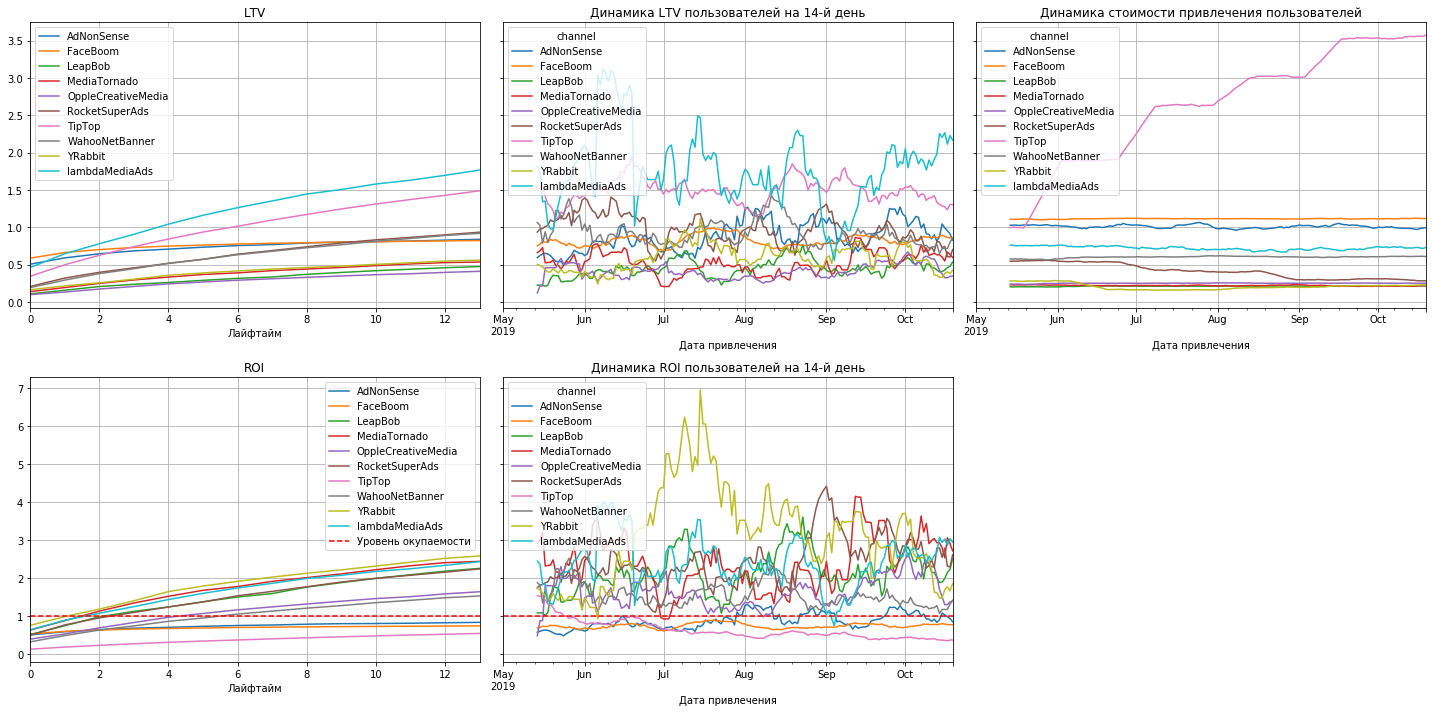

In [62]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Реклама окупается в зависимости от источника привлечения - те каналы, в которые компания вкладывалась больше всего - FaceBoom и TipToP - стабильно не окупались, вместе с AdNonSense, остальные же после первой недели уже вышли на окупаемость - и в лидерах находится YRabbit, вспомним, что он был одним из самых недорогих каналов, когда мы рассматривали таблицу с данными о затратах на покупателя.

Динамика привлечения стоимости пользователей четко показывает, что мы наблюдали до этого - затраты на TipToP очень сильно и постоянно росли, оставаясь стабильными для остальных источников. YRabbit показал очень высокую окупаемость особенно в июле и августе, будучи недорогим каналом. Также отметим хорошую окупаемость еще одного недорогого канала, RocketSuperAds. Таким образом, получается что больше всего денег было вложено в убыточные источники привлечения.

### 5.3. Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

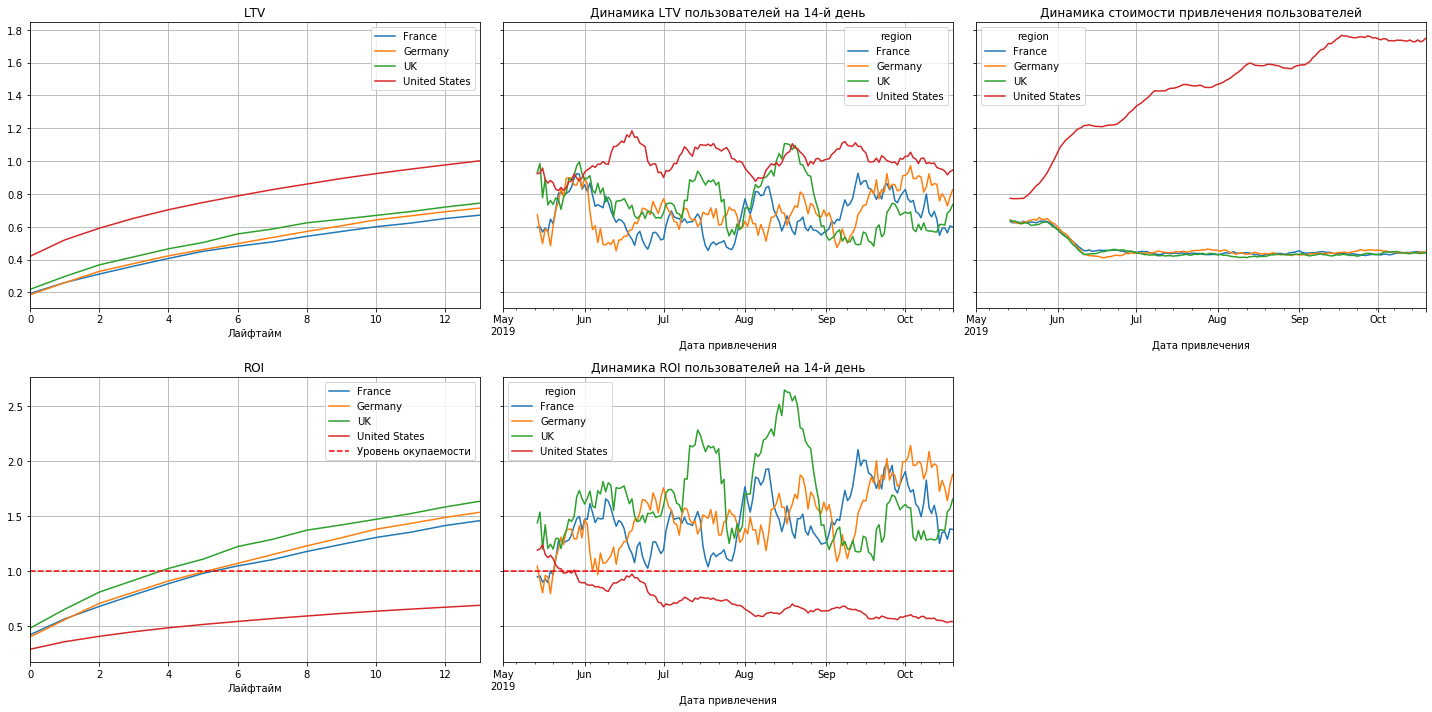

In [63]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Что касается стран, то страна, которя полностью не окупается - это США, откуда у нас подаляющее большинство пользователей и платящих пользователей. Пользователи из других стран окупались примерно после первой недели жизни. При этом у клиентов из США стабильный и более выскоий по сравнению с другими LTV.  Лучше всех окупается Великобритания. Стоимость привлечения пользователей по США стремительно выросла, по остальным странам была стабильна и практически одинакова. До июня пользователи из всех стран были по крайней мере выше уровня окупаемости, но к июню пользователи из США постоянно были убыточны. Остальные, особенно британцы, окупались, поднимаясь выше 2 только летом.

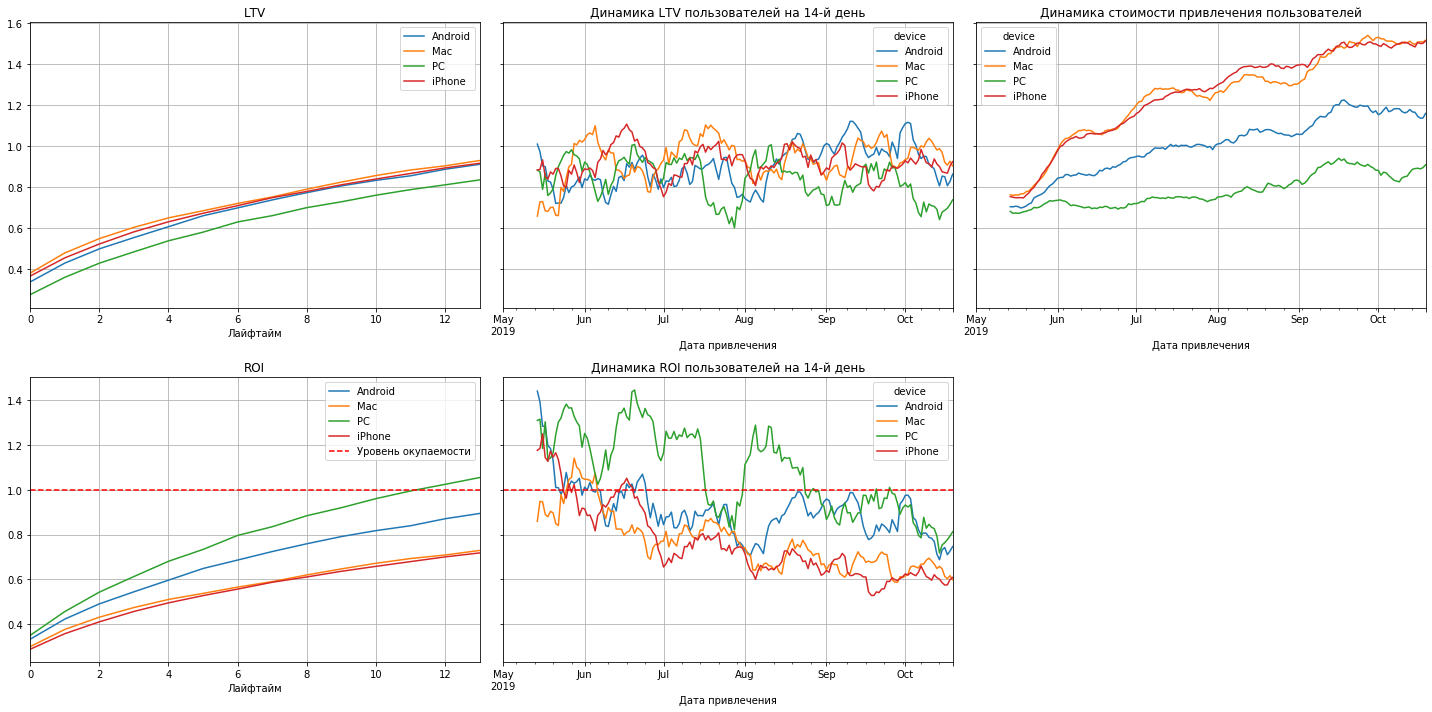

In [64]:
# смотрим окупаемость с разбивкой по устройствам т.к. до этого такого задания не было
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

По устройствам мы видим, что лучше всех окупается PC, Android едва окупается только к концу лайфтайма, а iPhone и Mac и вовсе не окупаются, при этом их стоимость привлечения самая высокая. Динамика ROI также показывает, что начиная с июля по всем устройствам кроме PC окупаемость опускалась ниже 1.

### 5.4. Постройте и изучите графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

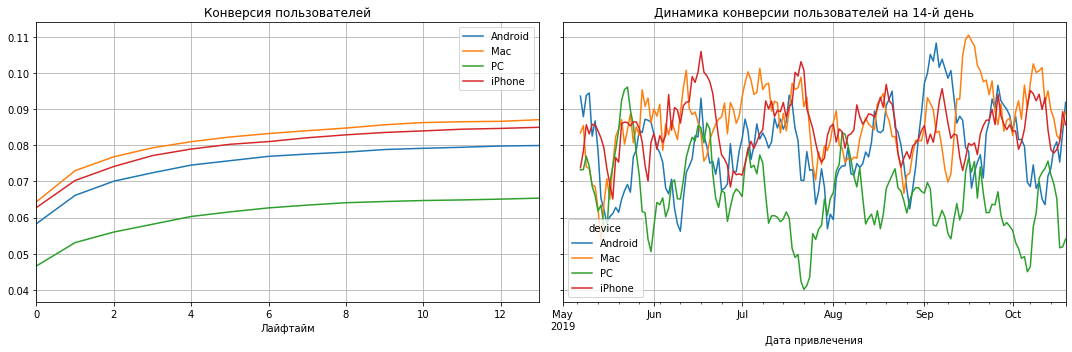

In [65]:
# смотрим конверсию с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

По дням лайфтайма, пользователи PC конвертировались существенно хуже остальных, а пользователи Mac лучше. Динамика конверсации на 14-ый день лучше у  Mac и i-Phone, но к концу периода Android приблизился к ним по результатам.

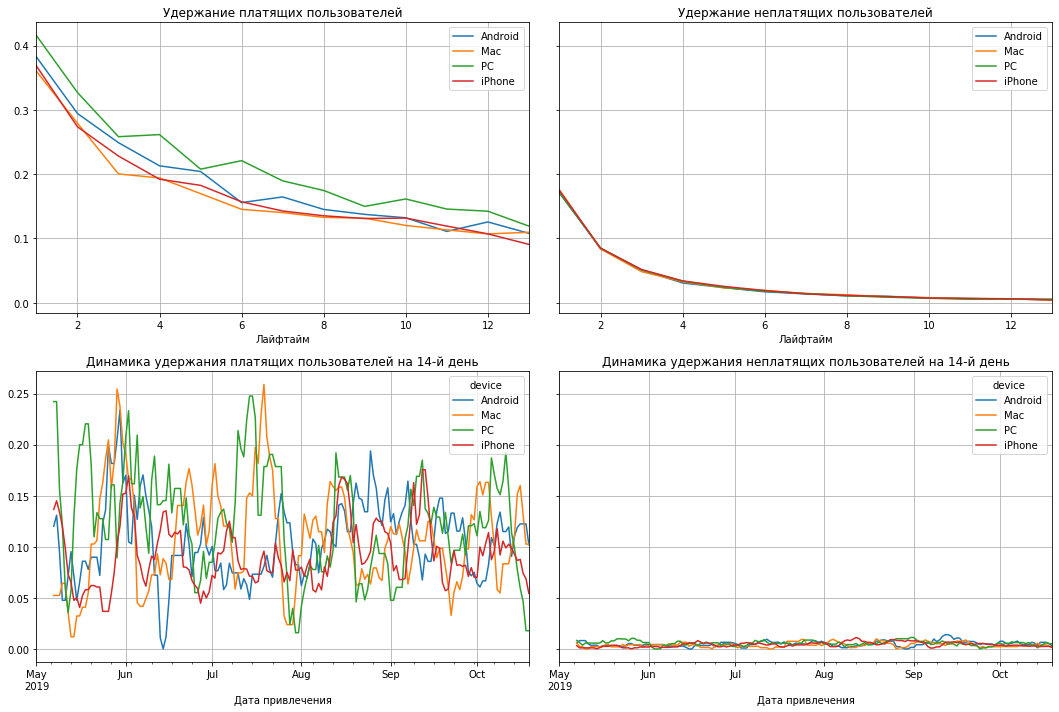

In [66]:
# смотрим удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

Платящие пользователи PC удерживаются немного лучше других, но разница не такая существенная.

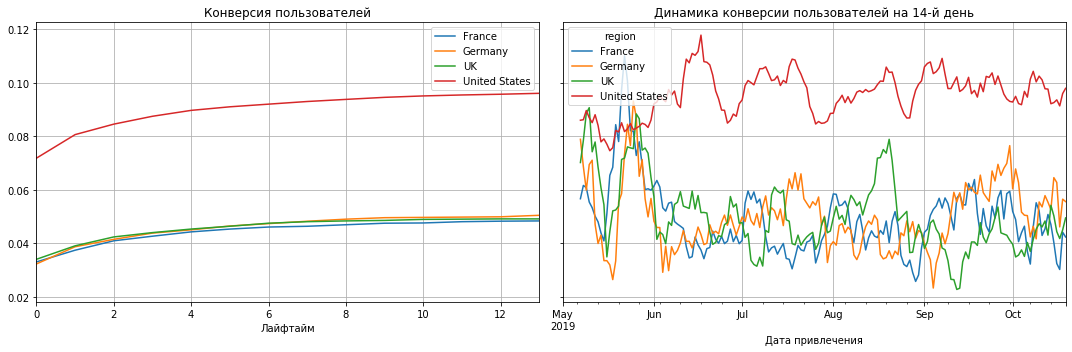

In [67]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи из США конвертируются очень хорошо, причём постоянно.

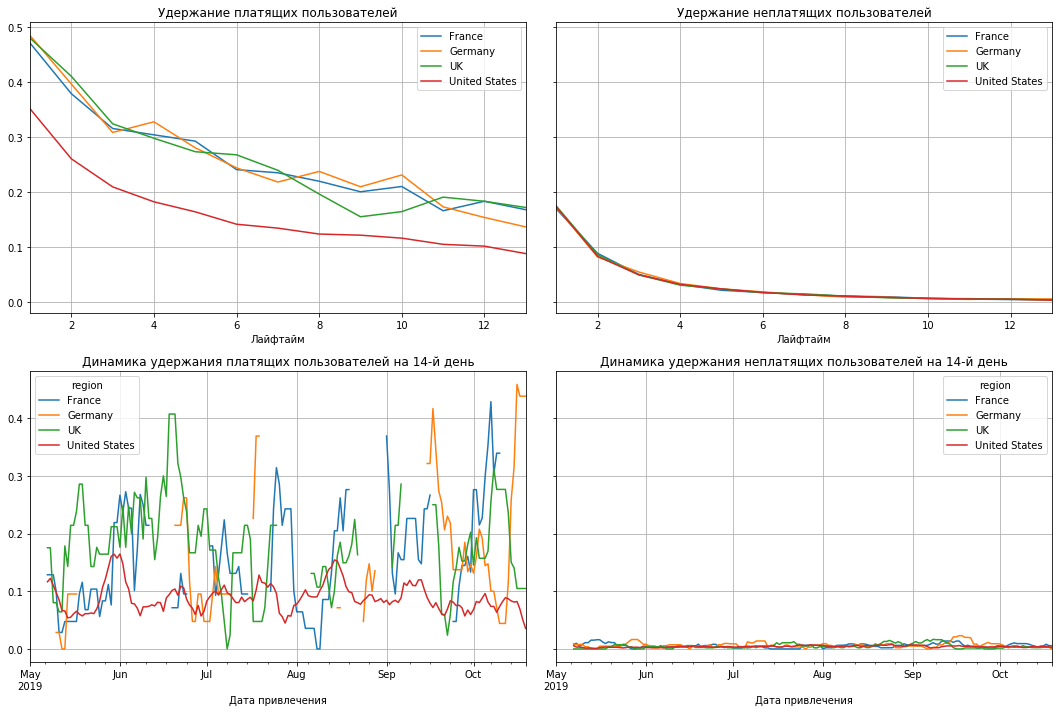

In [68]:
# смотрим удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

При этом платящие пользователи из США стабильно плохо удерживаются, примерно на 10% хуже, чем остальные. К концу периода динамика удержания по американцам заметно слабее, чем по европейцам, которые на конец периода демонстрируют высокий результаты.

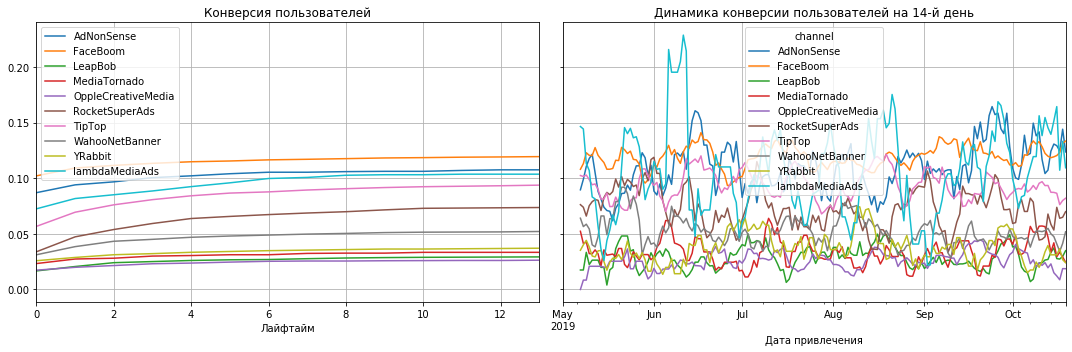

In [69]:
# смотрим конверсию с разбивкой по рекламным каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

FaceBoom конвертируется лучше других, причем делает это стабильно. LambdaMediaAds тоже показывает хорошую конверсию. TipTop показал неплохой результат коверсии, будучи четвертым.

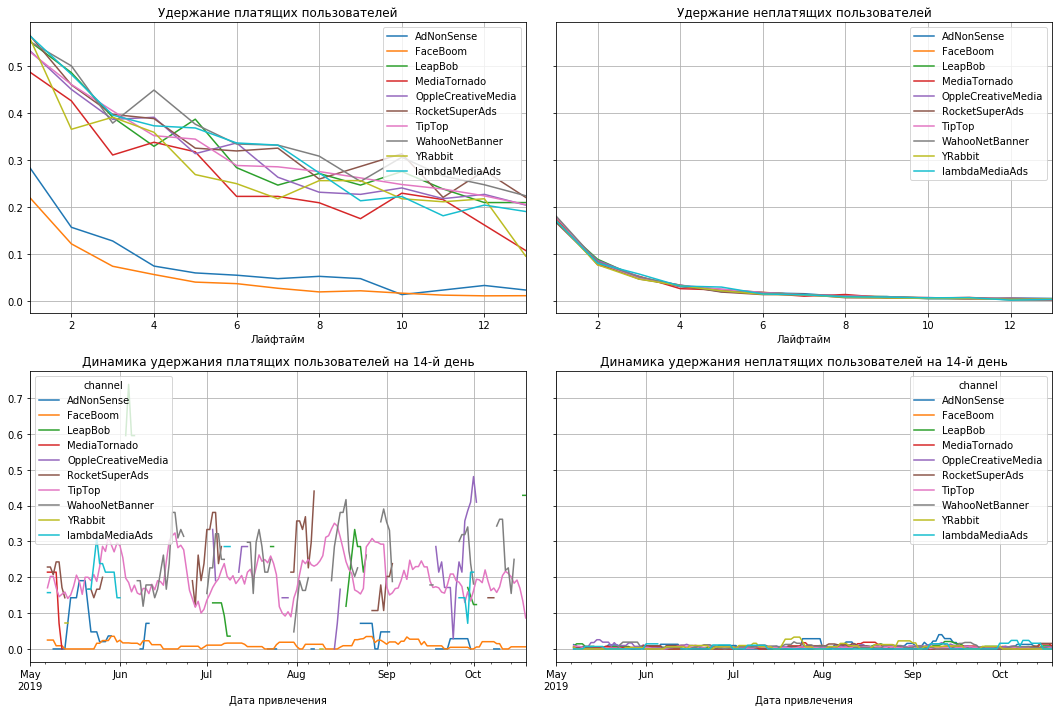

In [70]:
# смотрим удержание с разбивкой по рекламным каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Очень плохо по сравнению с остальными удерживаются пользователи FaceBoom и AdNonSense, к концу лайфтайма их удержание близко к нулю. На графике с динамикой удержания платных пользователей FaceBoom показал самый низкий результат. Зато TipTop удерживает довольно хорошо и стабильно по сравнению с ними.

### Выводы

Подведем итоги, собрав заключения сделанные по графикам.

*Окупается ли реклама в целом?*
В целом, реклама не окупается. ROI даже на 14-й день жизни пользователя находится ниже уровня окупаемости. Затраты на рекламу и стоимость привлечения пользователей с середины мая постоянно растут, а динамика ROI снижается, и с конца июля становится ниже уровня окупаемости.

*Какие устройства, страны и каналы могут снижать окупаемость рекламы?*
- Источники привлечения, на которые компания потратила больше всего средств - FaceBoom и TipToP - стабильно не окупались, при этом затраты на TipToP постоянно росли.
- Страна, которя полностью не окупается - это США, откуда у нас подаляющее большинство пользователей и платящих пользователей. При этом, стоимость привлечения пользователей по США стремительно выросла со временем.
- По устройствам нет ярко выраженных аутсайдеров, однако заметим, что несколько хуже окупаемость у iPhone и Mac, стоимость привлечения которых выше остальных.

*Чем могут быть вызваны проблемы окупаемости?* 
Проблемы окупаемости могут быть вызваны дорогой рекламой определенных каналов FaceBoom и TipToP, куда компания больше всего вкладывалась. FaceBoom при этом конвертируется лучше других, причем делает это стабильно. TipTop также показал неплохой результат коверсии. Пользователи FaceBoom дороги и плохо удерживаются по сравнению с остальными. TipToP хоть и дорог, но удерживает довольно хорошо и стабильно.

Страна, на которую идет ориентация, - США, не окупается, возможно, стоит переориентироваться на другие страны, показавшие лючший результат, как Великобритания. iPhone и Mac показывали хорошую конверсию, но низкое удержание. С удержанием платящих пользователей из США у нас также проблемы, несмотря на их хорошую конвертацию. Пользователи из США - аналогично пользователям iPhone и Mac: высокая конверсия и низкое удержание. 

В целом, создается впечатление, что там, где у нас хорошая конверсия происходит плохое удержание. 
Возможно, что-то происходит во время или после первой покупки. Платящие пользователи PC удерживаются немного лучше других, может быть что-то оказалось удобнее делать с компьютера.

*Опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела*
Довольно сложно предположить причины обнаруженных проблем, нам нужно больше информации о продукте Procrastinate Pro. 
Необходимо снижать затраты на TipToP и FaceBoom и возможно, вкладываться в более недорогие и хорошо окупаемые YRabbit и RocketSuperAds. Возможно, стоит подумать и переориентироваться на британский и европейский рынок. Также нам необходимо исследовать, что происходит после первой покупки, почему такое низкое удержание, почему нет повторных покупок в день и низкие результаты повторных покупок в неделю и месяц.

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

Подведем итоги нашей работы. 

Мы проанализировали 150008 профилей пользователей нашего приложения, среди которых 8881 платящих пользователей (около 6%), а также их покупки и затраты компании на маркетинг с 1 мая 2019 года по 27 октября 2019 года. 

Характеристики пользователей 

- Посетители приходят из США, Соединенного Королевства, Франции и Германии. Больше всего платящих пользователей приходят из США, 78% от всех платящих, остальные страны имеют схожие результат в районе 7-8%. Доля посетителей, ставших покупателями, в США лишь немного выше, чем в остальных странах (7% по сравнению с 4%). \

- Среди всех пользователей, у большинство владельцы iPhone - 36.32%, на остальные устройства приходится по 20%. При этом среди пользователей iPhone доля платящих совсем немного выше, чем средняя доля платящих пользователей от всех пользователей. Т.е. среди всех наших пользователей доля айфонщиков отличается от остальных, а среди платящих практически нет.

- Большинство пришедших пользователей пришли сами, они "органические" (38%), остальные приходят из FaceBoom - 19%, TipTop - 13% и других каналов, на которые приходится 5% и меньше. Среди пришедших с FaceBoom довольно высокий процент становятся платными пользователями - 12.2%, а также у AdNonSense и lambdaMediaAds - больше 10%, у TipTop 9.6%. Эти пользователи становятся платными чаще пришедших из других каналов. Из органических становятся покупателями лишь 2%, но зато их приход для компании не стоил затрат.

Метрики

Продукт:

- За весь период анализва, среднее количество уникальных пользователей в день было 1684, в неделю 7942, и в месяц 28989 человека. С июля наблюдался рост количества уникальный пользователей. Возможно, присутствовала сезонность.

- За день в среднем осуществлялось 1684 сессий, и это равно среднему количество уникальных пользователей. Один пользователь в среднем проводит в приложении максимум одну сессию в день. Пользователи заходят в приложение максимум один раз в день, 1.37 раз в неделю , а в месяц - 1.78, т.е. немного меньше, чем 2 раза месяц. Это довольно нечастно.

- В среднем пользователи проводят в приложении около 26 минут (медианное среднее). Это хороший результат, значит пользователи проводят много времени за сессию в приложении. 

Продажи:

- С момента первого посещения до покупки в среднем проходит одна минуту и 10 секунд (медианное среднее). 75% всех платящих пользователей совершили свою первую покупку менее чем через один день и 11 часов.

- В среднем платящий пользователь совершает одну покупку в день, 1.32 покупки в неделю и 2.23 покупки в месяц. С июля среднее число покупок на платящего начало снижаться, при этом наблюдалось общее увеличение количества посетителей. 

- Средний чек за день, неделю и месяц практические одинаковый, 5.4 у.е. Размер средний чек достиг своего пика в июля и далее снижался. При этом общее количество совершенных покупок со временем росло, так же как и общее количество доходов с них. Покупок стало больше, но тратить на покупку стали со временем немного меньше.

Маркетинг:

- Расходы на маркетинг составили 105497 у.е. Более половины всех затрат (52%) были направлены на TipTop, на FaceBoom 31%, а на остальные каналы меньше 5%. Со временем затраты постоянно росли, при этом резкий рост начался с июня. Затраты на TipTop с июня переживали сильный и постоянный рост.  Затраты на FaceBoom не слишком росли со временем, сильно увеличившись только в начале периода, с мая по июнь. По остальным каналам затраты не сильно менялись со временем.

- Привелечение платящих пользователей обошлось в среднем в 13.7 у.е. Самые "дорогие пользователи" из TipTop (29.15 у.е.). FaceBoom-еры обошлись дешевле - в 9.12 у.е. и самые "дешевые" пришли из RocketSuperAds - 5.21 у.е. FaceBoom принес нам больше всего покупателей в абсолютных числах, а на втором - органика. 

Окупаемость рекламы для привлечения пользователей

- Реклама не окупается. Затраты на рекламу и стоимость привлечения пользователей с середины мая постоянно растут, а динамика ROI снижается, и с конца июля становится ниже уровня окупаемости.

- FaceBoom и TipToP - стабильно не окупались, при этом затраты на TipToP постоянно росли.
- США - страна, которя полностью не окупается, при этом оттуда у нас подаляющее большинство пользователей и платящих пользователей. При этом, стоимость привлечения пользователей по США стремительно выросла со временем.

Возможные причины неэффективности и рекомендации

- Проблемы окупаемости могут быть вызваны дорогой рекламой определенных каналов FaceBoom и TipToP, куда компания больше всего вкладывалась. Пользователи FaceBoom дороги и плохо удерживаются по сравнению с остальными. TipToP хоть и дорог, но удерживает довольно неплохо и стабильно. Чтобы повысить эффективость необходимо снизить затраты по каналам TipToP и FaceBoom и рассмотреть большие вложения в другие каналы, например, - YRabbit и RocketSuperAds. Возможно, стоит обратить больше внимания на пользователей из Великобритании и Европы и каналы их привлечения.

- Причинами неэффективности привлечения пользователей являются скорее всего неверно выбранные источники привлечения и основная ориентация на США. При этом у нас есть проблемы с удержанием категорий пользователей, которые изначально хорошо конвертируются, - пользователи из США, но которые очень плохо удерживаются. Нам необходимо исследовать, почему пользователи из США так сильно отличаются по удержанию. Схожая ситуация наблюдалай и по устройствам - iPhone и Mac показывали хорошую конверсию, но низкое удержание. Возможно, возникают проблемы с первой покупкой или после ее совершения. Также нам необходимо исследовать, почему нет повторных сессий и покупок в день, найти причины низких результатов повторных покупок в неделю и месяц. Стоит также обратить внимание и на то, что именно произошло в июле, когда увеличилось число посетителей и покупателей, но средний чек при этом уменьшился.